# **Improving MTA rider experience via analyzing contributing factors of additional wait times and subway failures**

We will fit 3 models:

* Weibull regression with covariates on *additional platform stop time*
* Weibull regression with covariates on *additional train time*
* Negative binomial regression with covariates on *mean distance between failures*

In [86]:
import pandas as pd 
import numpy as np 
from datetime import datetime as dt 
from statsmodels.formula.api import poisson, negativebinomial
from statsmodels.base.model import GenericLikelihoodModel
import matplotlib.pyplot as plt
import scipy.stats as spst
import scipy.special as spsp
from statsmodels.tools.tools import add_constant
import scipy.integrate as integrate
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

## 1. Explore the Data

In [87]:
mdbf = pd.read_csv('mta_mdbf_subway.csv')
metrics = pd.read_csv('mta_subway_metrics.csv')

In [88]:
mdbf.head()

,month,car class,mdbf
0,2022-08,A DIVISION,187594
1,2022-08,B DIVISION,123792
2,2022-08,FLEET,145581
3,2022-08,R142,240935
4,2022-08,R142A,155761


In [89]:
mdbf['car class'].value_counts()

R68                  91
FLEET                91
R142                 91
R142A                91
R143                 91
R160                 91
R68A                 91
R188 - NEW           91
R46                  91
R62                  91
R62A                 91
R42                  82
R188 - CONVERSION    78
R32                  72
B DIVISION           42
A DIVISION           42
R179                 40
Name: car class, dtype: int64

In [90]:
metrics.head()

,month,division,line,period,num_passengers,additional platform time,additional train time,customer journey time performance
0,2022-08,A DIVISION,1,offpeak,4473384.7,0.94,0.67,0.884
1,2022-08,A DIVISION,1,peak,4430001.1,0.91,0.45,0.919
2,2022-08,A DIVISION,2,offpeak,2807806.4,1.33,0.50,0.831
3,2022-08,A DIVISION,2,peak,3021303.1,1.09,0.16,0.886
4,2022-08,A DIVISION,3,offpeak,1988021.0,0.93,0.37,0.882


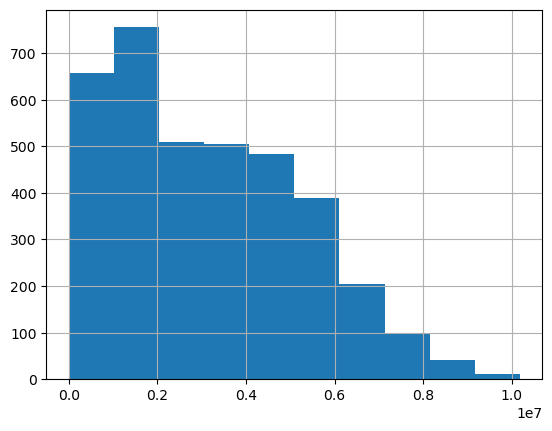

In [91]:
metrics['num_passengers'].hist()
plt.show()

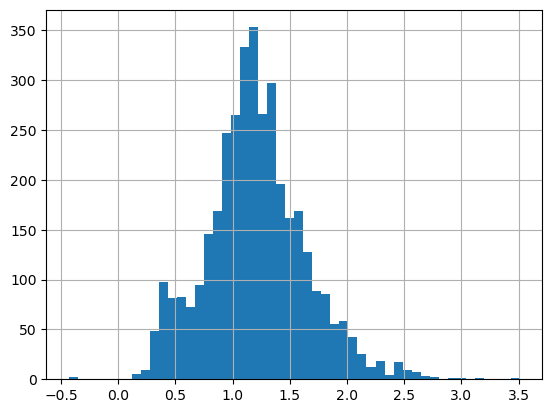

In [92]:
metrics['additional platform time'].hist(bins=50)
plt.show()

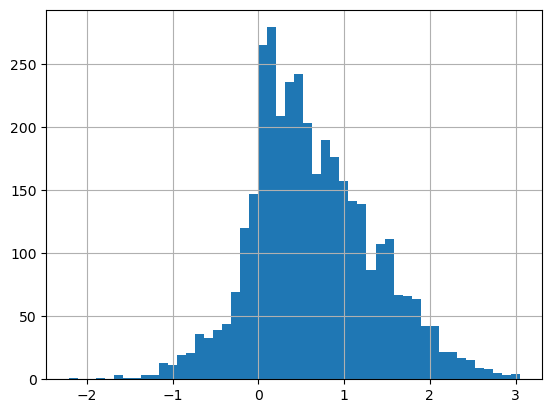

In [93]:
metrics['additional train time'].hist(bins=50) # is negative somtimes, maybe weibull is a bad match?
plt.show()

## 2. Data Preprocessing

In [94]:
# create season buckets
seasons_dict = {1: 0, 2: 0, 3: 1, # 0: winter
               4: 1, 5: 1, 6: 2, # 1: spring
               7: 2, 8: 2, 9: 3, # 2: summer
               10: 3, 11: 3, 12: 0} # 3: fall

In [95]:
mdbf['month'] = pd.to_datetime(mdbf['month'], format='%Y-%m')
mdbf['year'] = mdbf['month'].dt.year
mdbf['month'] = mdbf['month'].dt.month
mdbf = mdbf[mdbf['year'] != 2020] # get rid of covid year
mdbf['season'] = mdbf['month'].apply(lambda x: seasons_dict[x]) # assign season 
mdbf.rename(columns={'car class': 'car_class'}, inplace=True)
mdbf_a = mdbf[mdbf['car_class'] == 'A DIVISION']
mdbf_b = mdbf[mdbf['car_class'] == 'B DIVISION']
mdbf = pd.concat([mdbf_a, mdbf_b])
mdbf['car_class'] = mdbf['car_class'].map({'A DIVISION': 0, 'B DIVISION': 1}) # assign car class
mdbf.head()

,month,car_class,mdbf,year,season
0,8,0,187594,2022,2
15,7,0,192223,2022,2
30,6,0,190264,2022,2
45,5,0,184371,2022,1
60,4,0,182266,2022,1


In [96]:
metrics['month'] = pd.to_datetime(metrics['month'], format='%Y-%m')
metrics['year'] = metrics['month'].dt.year
metrics['month'] = metrics['month'].dt.month
metrics = metrics[metrics['year'] != 2020] # get rid of covid year
metrics['season'] = metrics['month'].apply(lambda x: seasons_dict[x]) # assign season
metrics.rename(columns={'additional platform time' : 'additional_platform_time',
                        'additional train time': 'additional_train_time',
                        'customer journey time performance': 'customer_journey_time_performance'},
                        inplace=True)
metrics['period'] = metrics['period'].map({'peak': 1, 'offpeak': 0})
metrics['division'] = metrics['division'].map({'A DIVISION': 0, 'B DIVISION': 1}) # assign car class
metrics.head()

,month,division,line,period,num_passengers,additional_platform_time,additional_train_time,customer_journey_time_performance,year,season
0,8,0,1,0,4473384.7,0.94,0.67,0.884,2022,2
1,8,0,1,1,4430001.1,0.91,0.45,0.919,2022,2
2,8,0,2,0,2807806.4,1.33,0.50,0.831,2022,2
3,8,0,2,1,3021303.1,1.09,0.16,0.886,2022,2
4,8,0,3,0,1988021.0,0.93,0.37,0.882,2022,2


In [97]:
all_data = pd.DataFrame(columns=['month', 'year', 'division', 'period',
                                'num_passengers', 'additional_platform_time', 
                                'additional_train_time', 'customer_journey_time_performance',
                                'season', 'mdbf'])
for i, row in mdbf.iterrows():
    subset = metrics[metrics['month'] == row['month']]
    subset = subset[subset['year'] == row['year']]
    subset = subset[subset['division'] == row['car_class']]
    subset['mdbf'] = row['mdbf']
    subset = subset.drop(columns='line')
    all_data = all_data.append(subset, ignore_index=True)

'''
--- division ---
0 --> A DIVISION
1 --> B DIVISION

---- period ----
0 --> offpeak
1 --> peak
'''
all_data = all_data.join(pd.get_dummies(all_data['season']))
all_data['num_passengers'] = np.log(all_data['num_passengers'])
all_data = all_data.rename(columns={'num_passengers': 'log_num_passengers', 
                                    0: 'winter', 1: 'spring',
                                    2: 'summer', 3: 'autumn' })
all_data = all_data.drop(columns='season')
all_data = all_data.astype(float)
all_data.head()

,month,year,division,period,log_num_passengers,additional_platform_time,additional_train_time,customer_journey_time_performance,mdbf,winter,spring,summer,autumn
0,8.0,2022.0,0.0,0.0,15.313656,0.94,0.67,0.884,187594.0,0.0,0.0,1.0,0.0
1,8.0,2022.0,0.0,1.0,15.303910,0.91,0.45,0.919,187594.0,0.0,0.0,1.0,0.0
2,8.0,2022.0,0.0,0.0,14.847914,1.33,0.50,0.831,187594.0,0.0,0.0,1.0,0.0
3,8.0,2022.0,0.0,1.0,14.921199,1.09,0.16,0.886,187594.0,0.0,0.0,1.0,0.0
4,8.0,2022.0,0.0,0.0,14.502650,0.93,0.37,0.882,187594.0,0.0,0.0,1.0,0.0


In [98]:
all_data.corr()

,month,year,division,period,log_num_passengers,additional_platform_time,additional_train_time,customer_journey_time_performance,mdbf,winter,spring,summer,autumn
month,1.000000e+00,-3.153577e-01,-8.677374e-03,-7.393004e-19,0.131320,0.055943,0.103542,-0.037976,-4.561938e-02,-2.684096e-01,-4.025463e-01,1.425267e-01,5.767890e-01
year,-3.153577e-01,1.000000e+00,4.511622e-03,1.384554e-15,-0.226709,0.191253,-0.338538,-0.049227,2.836879e-01,5.764635e-03,1.638839e-01,6.496750e-02,-2.719051e-01
division,-8.677374e-03,4.511622e-03,1.000000e+00,-1.715101e-16,-0.215426,0.252841,0.253024,-0.428898,-9.202466e-01,1.059665e-02,-3.485583e-03,-3.757169e-03,-2.675902e-03
period,-7.393004e-19,1.384554e-15,-1.715101e-16,1.000000e+00,0.021451,-0.101059,-0.125784,0.185821,1.704374e-16,-2.611105e-17,8.704843e-18,3.096422e-17,-3.118620e-17
log_num_passengers,1.313200e-01,-2.267092e-01,-2.154260e-01,2.145060e-02,1.000000,0.337090,0.493776,-0.404995,8.957192e-02,-4.777877e-02,-4.132233e-02,2.791209e-02,6.472478e-02
additional_platform_time,5.594312e-02,1.912532e-01,2.528407e-01,-1.010592e-01,0.337090,1.000000,0.311797,-0.804374,-1.639120e-01,6.787312e-04,-7.511021e-02,6.353764e-02,1.035917e-02
additional_train_time,1.035424e-01,-3.385382e-01,2.530239e-01,-1.257835e-01,0.493776,0.311797,1.000000,-0.564308,-3.862331e-01,1.847745e-02,-9.423836e-02,3.656130e-03,8.473945e-02
customer_journey_time_performance,-3.797598e-02,-4.922731e-02,-4.288983e-01,1.858210e-01,-0.404995,-0.804374,-0.564308,1.000000,3.821513e-01,-3.875705e-02,6.550398e-02,-1.105690e-02,-2.152746e-02
mdbf,-4.561938e-02,2.836879e-01,-9.202466e-01,1.704374e-16,0.089572,-0.163912,-0.386233,0.382151,1.000000e+00,4.219071e-03,2.205925e-02,7.469711e-03,-3.870844e-02
winter,-2.684096e-01,5.764635e-03,1.059665e-02,-2.611105e-17,-0.047779,0.000679,0.018477,-0.038757,4.219071e-03,1.000000e+00,-3.289327e-01,-3.545621e-01,-2.525235e-01


## 3. Modeling `additional_platform_time`

Covariates:
- `division`
- `period`
- `log_num_passengers`
- `spring`
- `summer`
- `autumn`

In [99]:
covariates_platform = ['division', 'period', 'log_num_passengers', 'spring', 'summer', 'autumn']
y_platform = all_data['additional_platform_time']

In [100]:
class WB(GenericLikelihoodModel):
    def loglike(self, params):
        t, X = self.endog, self.exog
        X = add_constant(X)
        half = len(params)//2
        c = np.exp(X @ params[:half])
        lmbda = np.exp(X @ params[half:])
        likelihood = spst.weibull_min.pdf(x=t, c=c, scale=lmbda**(-1/c)) + 1E-20
        loglikelihood = np.log(likelihood)
        return np.sum(loglikelihood)

In [101]:
X_platform = all_data[covariates_platform]
platform_time = WB(y_platform, X_platform).fit(start_params=np.random.randn((len(covariates_platform)+1)*2)*1E-1)
xname = ['log_c0']
for cov in covariates_platform:
    xname.append('log_c_' + cov)
xname.append('log_lm0')
for cov in covariates_platform:
    xname.append('log_lm_' + cov)
platform_time.summary(xname=xname)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     WB Results                                     
====================================================================================
Dep. Variable:     additional_platform_time   Log-Likelihood:                -945.71
Model:                                   WB   AIC:                             1901.
Method:                  Maximum Likelihood   BIC:                             1928.
Date:                      Thu, 29 Dec 2022                                         
Time:                              09:47:50                                         
No. Observations:                      1530                                         
Df Residuals:                          1524                                         
Df Model:                                 5                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
log_c0                        0.1506      0.275      0.547      0.584      -0.389       0.690
log_c_division               -0.0821      0.044     -1.867      0.062      -0.168       0.004
log_c_period                  0.0110      0.039      0.285      0.776      -0.065       0.087
log_c_log_num_passengers      0.0780      0.018      4.273      0.000       0.042       0.114
log_c_spring                 -0.3279      0.080     -4.089      0.000      -0.485      -0.171
log_c_summer                 -0.0087      0.050     -0.174      0.862      -0.107       0.090
log_c_autumn                 -0.0246      0.055     -0.449      0.654      -0.132       0.083
log_lm0                      -0.7720      0.591     -1.307      0.191      -1.929       0.385
log_lm_division              -0.3176      0.086     -3.703      0.000      -0.486      -0.149
log_lm_period                -0.0045      0.080     -0.056      0.955      -0.160       0.152
log_lm_log_num_passengers    -0.0065      0.040     -0.163      0.870      -0.084       0.071
log_lm_spring                 0.0023      0.119      0.019      0.985      -0.231       0.236
log_lm_summer                -0.1537      0.109     -1.412      0.158      -0.367       0.060
log_lm_autumn                 0.0128      0.119      0.108      0.914      -0.220       0.246
=============================================================================================
"""

Now, for a significance level of 0.15, if the p-value is greater than 0.15, we set the coefficient to 0. 

In [102]:
platform_log_c = platform_time.params[:len(platform_time.params)//2]
platform_log_lm = platform_time.params[len(platform_time.params)//2:]
platform_c_pvals = platform_time.pvalues[:len(platform_time.pvalues)//2]
platform_lm_pvals = platform_time.pvalues[len(platform_time.pvalues)//2:]
covariates_index = np.append(['b0'], covariates_platform)
params = {'covariates': covariates_index, 
          'log_c': platform_log_c, 
          'c_pval': platform_c_pvals,
          'log_lm': platform_log_lm, 
          'lm_pval': platform_lm_pvals}
df_platform = pd.DataFrame(data = params)
df_platform['log_c'] = np.where(df_platform['c_pval'] > 0.15, 0, df_platform['log_c'])
df_platform['log_lm'] = np.where(df_platform['lm_pval'] > 0.15, 0, df_platform['log_lm'])
df_platform = df_platform.set_index('covariates')
df_platform

,log_c,c_pval,log_lm,lm_pval
covariates,,,,
b0,0.000000,0.584037,0.000000,0.191106
division,-0.082146,0.061881,-0.317577,0.000213
period,0.000000,0.776023,0.000000,0.955355
log_num_passengers,0.077974,0.000019,0.000000,0.870408
spring,-0.327930,0.000043,0.000000,0.984776
summer,0.000000,0.862143,0.000000,0.157955
autumn,0.000000,0.653502,0.000000,0.914240


In [103]:
def predict_platform(division, peak, passengers, spring, summer, autumn):
    # get passengers
    p_passengers = np.percentile(np.exp(all_data['log_num_passengers']), passengers * 100)
    sd_passengers = np.std(np.exp(all_data['log_num_passengers']))
    range_passengers = np.log(np.array([max(1,p_passengers-1.5*sd_passengers), p_passengers+1.5*sd_passengers]))
    
    # create sample vector
    X = [1, division, peak, np.log(p_passengers), spring, summer, autumn]

    # get parameters
    c = np.exp(np.dot(X, df_platform['log_c']))
    lmbda = np.exp(np.dot(X, df_platform['log_lm']))

    # empirical
    empirical_times = all_data.loc[(all_data['division'] == division) & 
                               (all_data['period'] == peak) &
                               (all_data['log_num_passengers'] >= range_passengers[0]) &
                               (all_data['log_num_passengers'] <= range_passengers[1]) &
                               (all_data['spring'] == spring) &
                               (all_data['summer'] == summer) &
                               (all_data['autumn'] == autumn)]['additional_platform_time']
    plt.hist(empirical_times, bins=15, density=True, label='Empirical')

    # theoretical
    t = np.linspace(0,3,5000)
    pdf = spst.weibull_min.pdf(x=t, c=c, scale=lmbda**(-1/c))
    plt.plot(t, pdf, label='Theoretical')

    plt.legend()
    plt.xlabel('additional_platform_time')
    plt.ylabel('Probability/Proportion')

    # get season
    season = 'Winter'
    if spring == 1: 
        season = 'Spring'
    elif summer == 1: 
        season = 'Summer'
    elif autumn == 1: 
        season = 'Autumn'
    division = 'A' if division == 0 else 'B'
    peak = 'Offpeak' if peak == 0 else 'Peak'
    title = 'Division: %s, Period: %s, %d%% Passengers, Season: %s' % (division, peak, passengers*100, season)
    plt.title(title)
    plt.show()

    print('Empirical mean: %.3f' % np.mean(empirical_times))
    print('Theoretical mean: %.3f' % (lmbda**(-1/c)*spsp.gamma(1+1/c)))

In [104]:
def find_hazard(division, peak, passengers, spring, summer, autumn):
    # get passengers
    p_passengers = np.percentile(np.exp(all_data['log_num_passengers']), passengers * 100)
    
    # create sample vector
    X = [1, division, peak, np.log(p_passengers), spring, summer, autumn]

    # get parameters
    c = np.exp(np.dot(X, df_platform['log_c']))
    lmbda = np.exp(np.dot(X, df_platform['log_lm']))

    # hazard
    t = np.linspace(0,3,5000)
    hazard = c*lmbda*t**(c-1)
    plt.plot(t, hazard)

    plt.xlabel('additional_platform_time')
    plt.ylabel('Hazard')

    # get season
    season = 'Winter'
    if spring == 1: 
        season = 'Spring'
    elif summer == 1: 
        season = 'Summer'
    elif autumn == 1: 
        season = 'Autumn'
    division = 'A' if division == 0 else 'B'
    peak = 'Offpeak' if peak == 0 else 'Peak'
    title = 'Hazard for Division: %s, Period: %s, %d%% Passengers, Season: %s' % (division, peak, passengers*100, season)
    plt.title(title)
    plt.show()

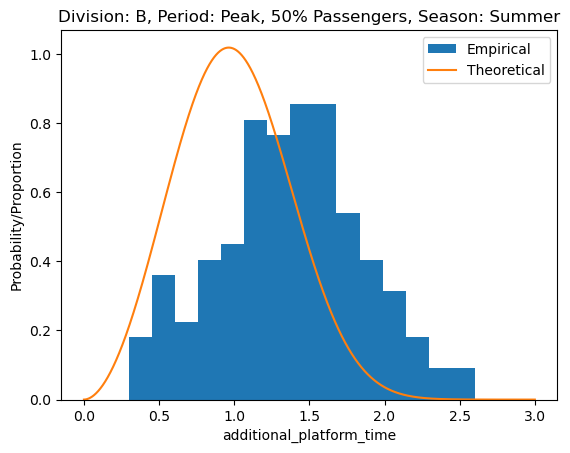

Empirical mean: 1.372
Theoretical mean: 0.995


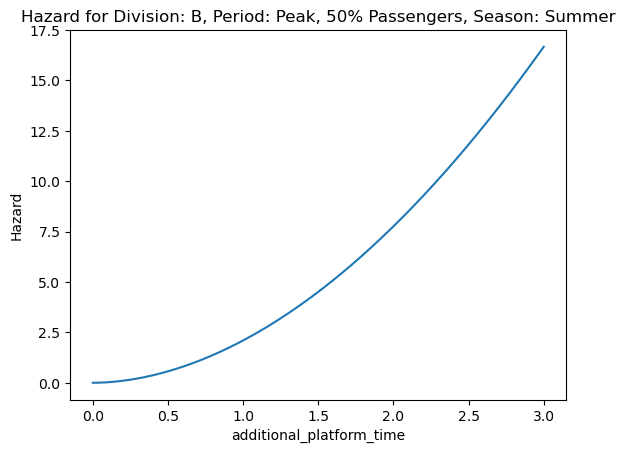

In [105]:
predict_platform(1, 1, 0.5, 0, 1, 0)
find_hazard(1, 1, 0.5, 0, 1, 0)

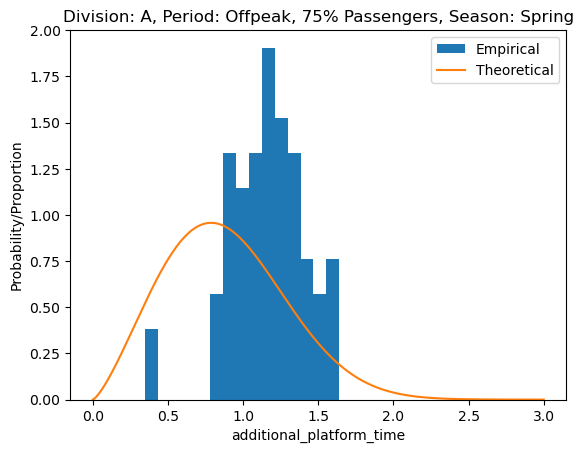

Empirical mean: 1.161
Theoretical mean: 0.886


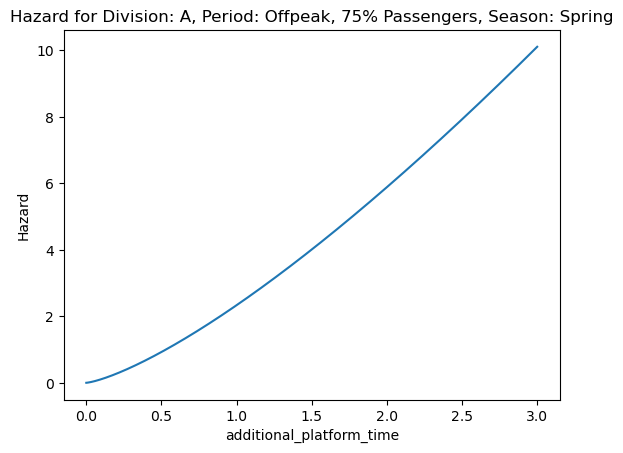

In [106]:
predict_platform(0, 0, 0.75, 1, 0, 0)
find_hazard(0, 0, 0.75, 1, 0, 0)

## 4. Modelling `additional_train_time`

In [107]:
# since some values of additional_train_time are negative, 
# we will translate the data by min_time and then translate it back later
min_time = -min(all_data['additional_train_time']) + 0.1
covariates_train = ['division', 'period', 'log_num_passengers', 'spring', 'summer', 'autumn']
y_train = all_data['additional_train_time'] + min_time

In [108]:
X_train = all_data[covariates_train]
train_time = WB(y_train, X_train).fit(start_params=np.random.randn((len(covariates_train)+1)*2)*1E-1)
xname = ['log_c0']
for cov in covariates_train:
    xname.append('log_c_' + cov)
xname.append('log_lm0')
for cov in covariates_train:
    xname.append('log_lm_' + cov)
train_time.summary(xname=xname)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    WB Results                                   
=================================================================================
Dep. Variable:     additional_train_time   Log-Likelihood:                -1247.9
Model:                                WB   AIC:                             2506.
Method:               Maximum Likelihood   BIC:                             2532.
Date:                   Thu, 29 Dec 2022                                         
Time:                           09:47:51                                         
No. Observations:                   1530                                         
Df Residuals:                       1524                                         
Df Model:                              5                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
log_c0                       -0.0582      0.341     -0.171      0.864      -0.726       0.610
log_c_division               -0.1203      0.046     -2.643      0.008      -0.210      -0.031
log_c_period                 -0.1834      0.040     -4.528      0.000      -0.263      -0.104
log_c_log_num_passengers      0.0951      0.022      4.324      0.000       0.052       0.138
log_c_spring                 -0.2948      0.072     -4.072      0.000      -0.437      -0.153
log_c_summer                 -0.0725      0.047     -1.541      0.123      -0.165       0.020
log_c_autumn                  0.0607      0.078      0.777      0.437      -0.092       0.214
log_lm0                      -0.4339      0.595     -0.729      0.466      -1.601       0.733
log_lm_division              -0.1772      0.104     -1.703      0.089      -0.381       0.027
log_lm_period                 0.3103      0.096      3.242      0.001       0.123       0.498
log_lm_log_num_passengers    -0.0631      0.039     -1.612      0.107      -0.140       0.014
log_lm_spring                -0.1593      0.136     -1.175      0.240      -0.425       0.106
log_lm_summer                -0.2621      0.115     -2.284      0.022      -0.487      -0.037
log_lm_autumn                -1.1952      0.215     -5.561      0.000      -1.616      -0.774
=============================================================================================
"""

In [109]:
train_log_c = train_time.params[:len(train_time.params)//2]
train_log_lm = train_time.params[len(train_time.params)//2:]
train_c_pvals = train_time.pvalues[:len(train_time.pvalues)//2]
train_lm_pvals = train_time.pvalues[len(train_time.pvalues)//2:]
covariates_index = np.append(['b0'], covariates_train)
params = {'covariates': covariates_index, 
          'log_c': train_log_c, 
          'c_pval': train_c_pvals,
          'log_lm': train_log_lm, 
          'lm_pval': train_lm_pvals}
df_train = pd.DataFrame(data = params)
df_train['log_c'] = np.where(df_train['c_pval'] > 0.15, 0, df_train['log_c'])
df_train['log_lm'] = np.where(df_train['lm_pval'] > 0.15, 0, df_train['log_lm'])
df_train = df_train.set_index('covariates')
df_train

,log_c,c_pval,log_lm,lm_pval
covariates,,,,
b0,0.000000,0.864320,0.000000,4.660959e-01
division,-0.120327,0.008223,-0.177221,8.854918e-02
period,-0.183394,0.000006,0.310330,1.186878e-03
log_num_passengers,0.095092,0.000015,-0.063111,1.070092e-01
spring,-0.294779,0.000047,0.000000,2.397979e-01
summer,-0.072510,0.123371,-0.262110,2.236240e-02
autumn,0.000000,0.437035,-1.195193,2.678956e-08


In [110]:
def predict_train(division, peak, passengers, spring, summer, autumn):
    # get passengers
    p_passengers = np.percentile(np.exp(all_data['log_num_passengers']), passengers * 100)
    sd_passengers = np.std(np.exp(all_data['log_num_passengers']))
    range_passengers = np.log(np.array([max(1,p_passengers-1.5*sd_passengers), p_passengers+1.5*sd_passengers]))
    
    # create sample vector
    X = [1, division, peak, np.log(p_passengers), spring, summer, autumn]

    # get parameters
    c = np.exp(np.dot(X, df_train['log_c']))
    lmbda = np.exp(np.dot(X, df_train['log_lm']))

    # empirical
    empirical_times = all_data.loc[(all_data['division'] == division) & 
                               (all_data['period'] == peak) &
                               (all_data['log_num_passengers'] >= range_passengers[0]) &
                               (all_data['log_num_passengers'] <= range_passengers[1]) &
                               (all_data['spring'] == spring) &
                               (all_data['summer'] == summer) &
                               (all_data['autumn'] == autumn)]['additional_train_time']
    plt.hist(empirical_times, bins=15, density=True, label='Empirical')

    # theoretical
    t = np.linspace(0,3,5000)
    pdf = spst.weibull_min.pdf(x=t, c=c, scale=lmbda**(-1/c))
    plt.plot(t-min_time, pdf, label='Theoretical')

    plt.legend()
    plt.xlabel('additional_train_time')
    plt.ylabel('Probability/Proportion')

    # get season
    season = 'Winter'
    if spring == 1: 
        season = 'Spring'
    elif summer == 1: 
        season = 'Summer'
    elif autumn == 1: 
        season = 'Autumn'
    division = 'A' if division == 0 else 'B'
    peak = 'Offpeak' if peak == 0 else 'Peak'
    title = 'Division: %s, Period: %s, %d%% Passengers, Season: %s' % (division, peak, passengers*100, season)
    plt.title(title)
    plt.show()

    print('Empirical mean: %.3f' % np.mean(empirical_times))
    print('Theoretical mean: %.3f' % (lmbda**(-1/c)*spsp.gamma(1+1/c) - min_time))

In [111]:
def find_hazard(division, peak, passengers, spring, summer, autumn):
    # get passengers
    p_passengers = np.percentile(np.exp(all_data['log_num_passengers']), passengers * 100)
    
    # create sample vector
    X = [1, division, peak, np.log(p_passengers), spring, summer, autumn]

    # get parameters
    c = np.exp(np.dot(X, df_train['log_c']))
    lmbda = np.exp(np.dot(X, df_train['log_lm']))

    # hazard
    t = np.linspace(0,3,5000)
    ft = spst.weibull_min.pdf(x=t, c=c, scale=lmbda**(-1/c))
    Ft = spst.weibull_min.cdf(x=t, c=c, scale=lmbda**(-1/c))
    #hazard = c*lmbda*t**(c-1)
    hazard = ft / (1-Ft)
    plt.plot(t-min_time, hazard)

    plt.xlabel('additional_train_time')
    plt.ylabel('Hazard')

    # get season
    season = 'Winter'
    if spring == 1: 
        season = 'Spring'
    elif summer == 1: 
        season = 'Summer'
    elif autumn == 1: 
        season = 'Autumn'
    division = 'A' if division == 0 else 'B'
    peak = 'Offpeak' if peak == 0 else 'Peak'
    title = 'Hazard for Division: %s, Period: %s, %d%% Passengers, Season: %s' % (division, peak, passengers*100, season)
    plt.title(title)
    plt.show()

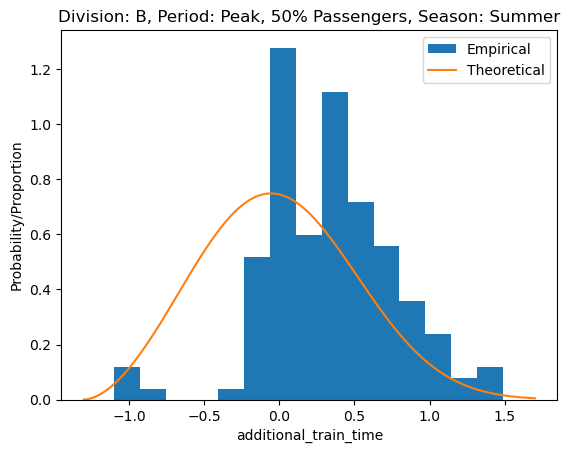

Empirical mean: 0.330
Theoretical mean: 0.003


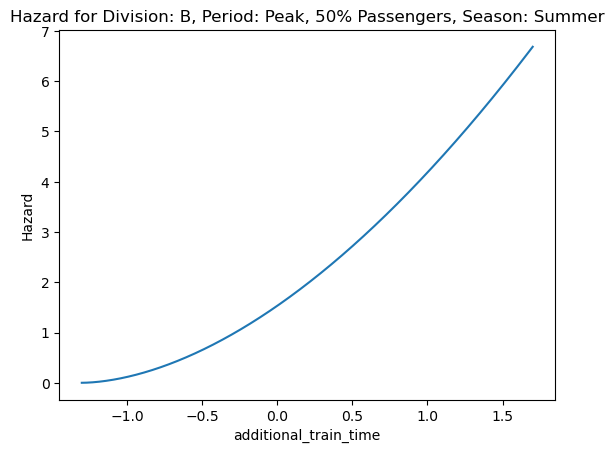

In [112]:
predict_train(1, 1, 0.5, 0, 1, 0)
find_hazard(1, 1, 0.5, 0, 1, 0)

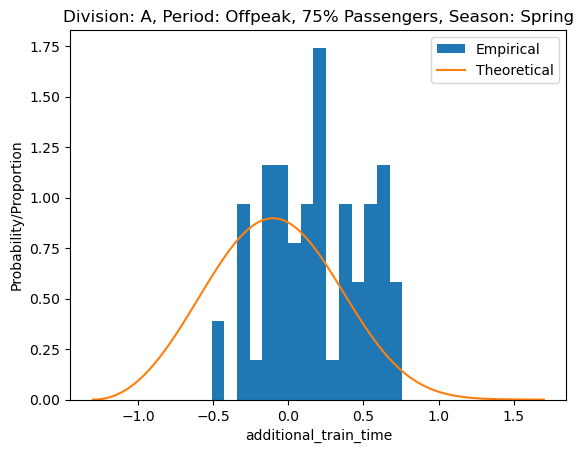

Empirical mean: 0.183
Theoretical mean: -0.087


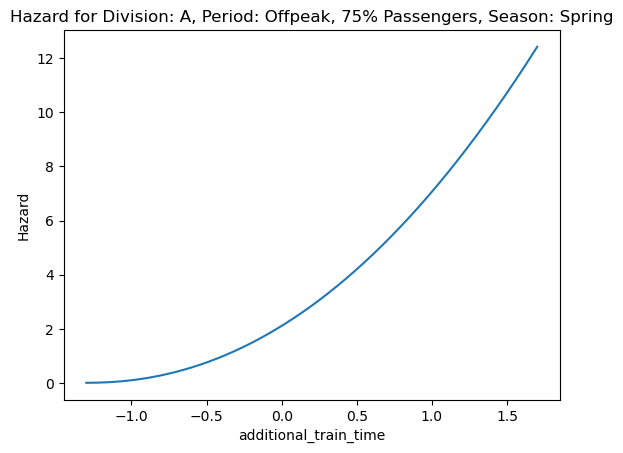

In [113]:
predict_train(0, 0, 0.75, 1, 0, 0)
find_hazard(0, 0, 0.75, 1, 0, 0)

## 5. NBD Regression on MDBF

In [114]:
mdbf_covs = 'division+period+log_num_passengers+spring+summer+autumn'
mdbf_model = negativebinomial('mdbf~' + mdbf_covs, all_data).fit(disp=0)
mdbf_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                   mdbf   No. Observations:                 1530
Model:               NegativeBinomial   Df Residuals:                     1523
Method:                           MLE   Df Model:                            6
Date:                Thu, 29 Dec 2022   Pseudo R-squ.:                 0.08795
Time:                        09:47:51   Log-Likelihood:                -16440.
converged:                      False   LL-Null:                       -18025.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             12.4356      0.026    477.648      0.000      12.385      12.487
division              -0.4522      0.005   -100.072      0.000      -0.461      -0.443
period                 0.0010      0.004      0.251      0.802      -0.007       0.009
log_num_passengers    -0.0203      0.002    -11.668      0.000      -0.024      -0.017
spring                 0.0021      0.006      0.356      0.722      -0.010       0.014
summer                -0.0030      0.006     -0.511      0.609      -0.014       0.008
autumn                -0.0239      0.007     -3.632      0.000      -0.037      -0.011
alpha                  0.0066      0.000     27.660      0.000       0.006       0.007
======================================================================================
"""

In [115]:
def predict_mdbf(division, peak, passengers, spring, summer, autumn, model):
    # get passengers
    p_passengers = np.percentile(np.exp(all_data['log_num_passengers']), 100 * passengers)
    sd_passengers = np.std(np.exp(all_data['log_num_passengers']))
    range_passengers = np.log(np.array([max(1,p_passengers-2*sd_passengers), p_passengers+2*sd_passengers]))
    
    # create sample vector
    X = [division, peak, np.log(p_passengers), spring, summer, autumn]

    # get parameters
    gamma = 1 / model.params[-1]
    alpha = gamma / np.exp(model.params[0])
    alpha /= np.exp(np.dot(X, model.params[1:-1]))
    n, p = gamma, alpha/(alpha+1)

    # empirical
    empirical_times = all_data.loc[(all_data['division'] == division) & 
                               (all_data['period'] == peak) &
                               (all_data['log_num_passengers'] >= range_passengers[0]) &
                               (all_data['log_num_passengers'] <= range_passengers[1]) &
                               (all_data['spring'] == spring) &
                               (all_data['summer'] == summer) &
                               (all_data['autumn'] == autumn)]['mdbf']
    plt.hist(empirical_times, bins=15, density=True, label='Empirical')

    # theoretical
    x = np.arange(spst.nbinom.ppf(0.0001, n, p), spst.nbinom.ppf(0.9999, n, p))
    pmf = spst.nbinom.pmf(x, n=n, p=alpha/(alpha+1))
    plt.plot(x, pmf, label='Theoretical')

    plt.legend()
    plt.xlabel('mean distance between failures')
    plt.ylabel('Probability/Proportion')

    # get season
    season = 'Winter'
    if spring == 1: 
        season = 'Spring'
    elif summer == 1: 
        season = 'Summer'
    elif autumn == 1: 
        season = 'Autumn'
    division = 'A' if division == 0 else 'B'
    peak = 'Offpeak' if peak == 0 else 'Peak'
    title = 'Division: %s, Period: %s, %d%% Passengers, Season: %s' % (division, peak, passengers*100, season)
    plt.title(title)
    plt.show()

    print('Empirical mean: %.3f' % np.mean(empirical_times))
    print('Theoretical mean: %.3f' % (gamma/alpha))

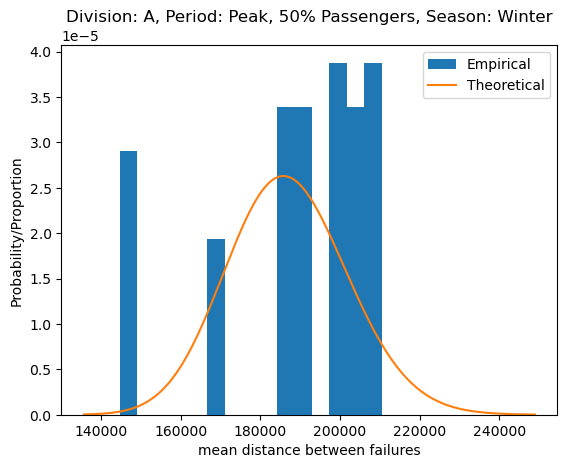

Empirical mean: 189758.532
Theoretical mean: 187006.344


In [116]:
predict_mdbf(0, 1, 0.5, 0, 0, 0, mdbf_model)

## 6. Optimizing decision-maker's revenue by choosing the number of passengers that maximizes the revenue:


$$ \mathbb{E} [R] = \$2.75 \times \mathbb{E}[P] $$
where $R$ is the revenue and $P$ is the number of passengers. 
Thus, in order to maximize the revenue, we need to maximize the number of passengers.

Assume that if the wait time (`additional_platform_time` + `additional_train_time`) is too long, the number of passengers will decrease since consumers will choose to take an alternative form of transportation that is faster. We will model this by a loss rate $L(t) = \frac{1}{1+e^{-t}}$. For example, for a total wait time of 3 minutes, $L(3) \times P$  number of passengers  will leave.


So, the decision maker chooses 
$$P = \argmax_p \Sigma_{\mathbb{S}(\text{covariates} \backslash \text{passengers})} \mathbb{P}(\mathbb{S}) \int_{t=0}^{\infty} (1-L(t)) *p *f(t | \mathbb{S} \cap p) dt$$

where $f(t | \mathbb{S} \cap p)$ is the distribution of total wait time given a set of covariates. The intuition for this equation comes from iterating through all potential wait times for given sets of covariates to get the expected number of customers. 

To find $f(t | \mathbb{S} \cap p)$, we assume `additional_platform_time` and `additional_train_time` are independent, which implies that $f(pt, tt) = f_{PT}(pt) f_{TT}(tt)$, for simplicity. Thus, we find
$$ f(t) = \int_0^t f_{PT}(pt) f_{TT}(t-pt) dpt$$

In future iterations, however,  we should not assume independence as there's a correlation of about 0.3 between `additional_platform_time` and `additional_train_time`.

In [117]:
# cov = [division, period, passengers, spring, summer, autumn]
def pdf_t(t, cov):
    X = np.concatenate(([1], cov))
    # platform
    c_pt = np.exp(np.dot(X, df_platform['log_c']))
    lmbda_pt = np.exp(np.dot(X, df_platform['log_lm']))
    # train
    c_tt = np.exp(np.dot(X, df_train['log_c']))
    lmbda_tt = np.exp(np.dot(X, df_train['log_lm']))

    result = integrate.quad(lambda x: pdf_pt(x, c_pt, lmbda_pt)*pdf_tt(t-x, c_tt, lmbda_tt), 0, t, limlst=3)
    return result[0]

def pdf_pt(t, c, lm):
    fpt = spst.weibull_min.pdf(x=t, c=c, scale=lm**(-1/c))
    return fpt

def pdf_tt(t, c, lm):
    ftt = spst.weibull_min.pdf(x=t, c=c, scale=lm**(-1/c))
    return ftt*(t-min_time >= 0)

In [125]:
# cov_wo_p = [division, period, spring, summer, autumn]
def exp_customers(cov_wo_p, p):
    p_passengers = np.percentile(np.exp(all_data['log_num_passengers']), p * 100)
    cov = np.insert(cov_wo_p, 2, np.log(p_passengers))
    result = integrate.quad(lambda t: (1-loss(t))*p_passengers*pdf_t(t,cov),1,5, limlst=3)
    return result[0]

def loss(t):
    return 1/(1+np.exp(-t))

def cov_probability(cov_wo_p):
    # get empirical proportion
    num = len(all_data.loc[(all_data['division'] == cov_wo_p[0]) & 
                               (all_data['period'] == cov_wo_p[1]) &
                               (all_data['spring'] == cov_wo_p[2]) &
                               (all_data['summer'] == cov_wo_p[3]) &
                               (all_data['autumn'] == cov_wo_p[4])])
    denom = len(all_data)
    return num/denom

def objective(p):
    total = 0
    for decision in [0,1]:
        for period in [0,1]:
            for season in ['spring','summer','autumn','winter']:
                cov_wo_p = np.concatenate(([decision, period], seasons_list(season)))
                total += cov_probability(cov_wo_p)*exp_customers(cov_wo_p, p)
    
    return -1*total

def seasons_list(season):
    return [int(season=='spring'), int(season=='summer'), int(season=='autumn')]

def find_argmax_p():
    bnds = (0,1)
    sol = minimize(objective,0.5,method='SLSQP',bounds=bnds)
    return sol

In [135]:
# optimal values
platform = [[-0.5034, 0.0811, -0.0982, 0.1210, 0, -0.2099, 0],
           [0, -0.3498, 0.1676, -0.0653, 0, 0, 0]]
train = [[0, -0.2203, -0.1589, 0.1102, 0, 0, -0.1766],
        [0, 0, 0.2849, -0.1694, 0, 0, 0]]

df_platform = pd.DataFrame({'log_c': platform[0], 'log_lm': platform[1]})
df_train = pd.DataFrame({'log_c': train[0], 'log_lm': train[1]})

In [138]:
for p in [0.25, 0.5, 0.75]:
    print('%.2f: %d' % (p,objective(p)))

0.25: -47843
0.50: -81605
0.75: -133031
